# Fine-Tuning P.1203 Model

# ITU-T P.1203

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from itu_p1203 import P1203Standalone
from itu_p1203 import P1203Pq
from itu_p1203 import P1203Pa
from itu_p1203 import P1203Pv
from itertools import permutations

import json


In [3]:
f = open("./mode0-bothtests.json")
input_data = json.load(f)
input_data

{'I11': {'segments': [], 'streamId': 42},
 'I13': {'segments': [{'codec': 'h264',
    'start': 0,
    'duration': 5,
    'resolution': '1920x1080',
    'bitrate': 16680,
    'fps': 30},
   {'codec': 'h264',
    'start': 5,
    'duration': 5,
    'resolution': '1920x1080',
    'bitrate': 16680,
    'fps': 30}],
  'streamId': 42},
 'I23': {'stalling': [], 'streamId': 42},
 'IGen': {'device': 'pc',
  'displaySize': '1920x1080',
  'viewingDistance': '150cm'}}

In [4]:
# Addendum 07.11: So I believe the bitrate values are all wrong here
# Firstly, Minh also appears to have used mbps in the p1203 calculation, which is wrong (or maybe was right at the time of the previous fine-tuning)
# Now the p1203 model clearly uses kbits/second

# I am collecting all video bitrates in bytes and then converting them to mbits/second, before multiplying them by 1000 to get kbits/second
# I am also only storing the bitrate in kbits to avoid confusion

# The way to get the megabits values is:
# 1. get the size of the bin file in bytes (or kilobytes)
# 2. convert it to megabits by dividing by 125000
# 3. divide it by 10 (since the bin file is for 10-seconds) to get megabits / second
# 4. multiply it by 1000 to get kbit/s
# All of our sequences are 10-second sequences, thus we divide by 10

In [5]:
import os

bitstream_folder = "./bitstream-files/"
for file_name in os.listdir(bitstream_folder):
    file_path = os.path.join(bitstream_folder, file_name)

    if os.path.isfile(file_path):
        file_size_kb = os.path.getsize(file_path) * 8 / 1024
        print(f"{file_name}: {file_size_kb:.2f} kilobits")
        #object_name = file_name.split(".")[0].split("-")[0]
        #quality = file_name.split(".")[0].split("-")[1]
        #print("\'" + object_name + "\'" + ": " + "{ " + "\'" + quality + "\'" + ": " + f"{file_size_kb:.2f}" + ", ")

BlueSpin-r1.bin: 14000.33 kilobits
BlueSpin-r2.bin: 18358.77 kilobits
BlueSpin-r3.bin: 25381.74 kilobits
BlueSpin-r4.bin: 60218.56 kilobits
BlueSpin-r5.bin: 100957.13 kilobits
CasualSquat-r1.bin: 20028.41 kilobits
CasualSquat-r2.bin: 31350.91 kilobits
CasualSquat-r3.bin: 53280.41 kilobits
CasualSquat-r4.bin: 156102.30 kilobits
CasualSquat-r5.bin: 248934.89 kilobits
FlowerDance-r1.bin: 21305.45 kilobits
FlowerDance-r2.bin: 33934.77 kilobits
FlowerDance-r3.bin: 57028.55 kilobits
FlowerDance-r4.bin: 182492.95 kilobits
FlowerDance-r5.bin: 314833.07 kilobits
longdress-r1.bin: 45330.51 kilobits
longdress-r3.bin: 137209.71 kilobits
longdress-r5.bin: 456825.40 kilobits
loot-r1.bin: 22223.74 kilobits
loot-r3.bin: 54941.94 kilobits
loot-r5.bin: 162842.81 kilobits
ReadyForWinter-r1.bin: 15823.20 kilobits
ReadyForWinter-r2.bin: 20687.30 kilobits
ReadyForWinter-r3.bin: 28919.76 kilobits
ReadyForWinter-r4.bin: 74742.73 kilobits
ReadyForWinter-r5.bin: 132748.28 kilobits
redandblack-r1.bin: 33068.13 k

In [6]:
# bitratesMbpsNew = {
#     'BlueSpin': {'r01': 1.75, 'r02': 2.29, 'r03': 3.17, 'r04': 7.53, 'r05': 12.62},
#     'CasualSquat':  {'r01': 2.50, 'r02': 3.91, 'r03': 6.66, 'r04': 19.51, 'r05': 31.11},
#     'ReadyForWinter':  {'r01': 1.97, 'r02': 2.58, 'r03': 3.61, 'r04': 9.34, 'r05': 16.59},
#     'FlowerDance':  {'r01': 2.66, 'r02': 4.24, 'r03': 7.12, 'r04': 22.81, 'r05': 39.35},
# }

bitrates_kbps_new = {
    'BlueSpin': {'r01': 14000.33, 'r02': 18358.77, 'r03': 25381.74, 'r04': 60218.56, 'r05': 100957.13},
    'CasualSquat':  {'r01': 20028.41, 'r02': 31350.91, 'r03': 53280.41, 'r04': 156102.30, 'r05': 248934.89},
    'ReadyForWinter': { 'r01': 15823.20, 'r02': 20687.30, 'r03': 28919.76, 'r04': 74742.73, 'r05': 132748.28 },
    'FlowerDance': { 'r01': 21305.45,  'r02': 33934.77,  'r03': 57028.55, 'r04': 182492.95, 'r05': 314833.07}
}

resolution_map_new = {
    'r01': '640x360', # worse than 420p
    'r02': '852x480', # exactly 480p
    'r03': '1192x672', # bit worse than 720p
    'r04': '1533x864', # a bit better than 720p
    'r05': '1920x1080', # exactly 1080p

}

# bitratesMbpsOld = {
#     'LongDress': {'r1': 4.64, 'r3': 14.05, 'r5':46.78},
#     'Loot': {'r1': 2.28, 'r3': 5.63, 'r5': 16.68},
#     'RedAndBlack': {'r1': 3.39, 'r3': 7.55, 'r5': 22.9},
#     'Soldier': {'r1': 4.38, 'r3': 11.58, 'r5': 35.29}
# }

bitrates_kbps_old = {
    'LongDress': { 'r1': 45330.51, 'r3': 137209.71, 'r5': 456825.40 },
    'Loot': { 'r1': 22223.74, 'r3': 54941.94, 'r5': 162842.81 },
    'RedAndBlack': { 'r1': 33068.13, 'r3': 73753.55, 'r5': 223673.06 },
    'Soldier': { 'r1': 42745.16, 'r3': 113102.48, 'r5': 344626.97 }
}

resolution_map_old = {
    'r1': '854x480', # old dataset 480p
    'r3': '1280x720', # old dataset 720p
    'r5': '1920x1080' # old dataset 1080p
}

In [7]:
p1203_results = {
    'object': [],
    'start_qual' : [],
    'end_qual' : [],
    'start_bitrate': [],
    'end_bitrate': [],
    'p1203_qoe': []
}

for video in list(bitrates_kbps_old.keys()):
    bitrate_permutations = permutations(list(bitrates_kbps_old[video].values()), 2)
    quality_permutations = permutations(list(bitrates_kbps_old[video].keys()),2)

    bitrates=list(bitrate_permutations)
    qualities = list(quality_permutations)

    for bitrate in list(bitrates_kbps_old[video].values()):
        bitrates.append((bitrate, bitrate))

    for quality in list(bitrates_kbps_old[video].keys()):
        qualities.append((quality, quality))

    for bitrate, quality in zip(bitrates, qualities):
        p1203_results['object'].append(video)
        p1203_results['start_qual'].append(quality[0])
        p1203_results['end_qual'].append(quality[1])
        p1203_results['start_bitrate'].append(bitrate[0])
        p1203_results['end_bitrate'].append(bitrate[1])

        input_data['I13']['segments'][0]['bitrate'] = bitrate[0]
        input_data['I13']['segments'][0]['resolution'] = resolution_map_old[quality[0]]
        input_data['I13']['segments'][1]['bitrate'] = bitrate[1]
        input_data['I13']['segments'][1]['resolution'] = resolution_map_old[quality[1]]

        # the old dataset videos are 30 fps and 10 seconds in sequence length
        input_data['I13']['segments'][0]['fps'] = 30
        input_data['I13']['segments'][1]['fps'] = 30
        input_data['I13']['segments'][0]['duration'] = 5
        input_data['I13']['segments'][1]['duration'] = 5
        input_data['I13']['segments'][1]['start'] = 5

        p1203_results['p1203_qoe'].append(P1203Standalone(input_data).calculate_complete()['O46'])

        print(video)
        print(input_data)
        

for video in list(bitrates_kbps_new.keys()):   
    bitrates = list(bitrates_kbps_new[video].values())
    qualities = list(bitrates_kbps_new[video].keys())

    for bitrate, quality in zip(bitrates, qualities):
        p1203_results['object'].append(video)
        p1203_results['start_qual'].append(quality)
        p1203_results['end_qual'].append(quality)
        p1203_results['start_bitrate'].append(bitrate)
        p1203_results['end_bitrate'].append(bitrate)

        input_data['I13']['segments'][0]['bitrate'] = bitrate
        input_data['I13']['segments'][0]['resolution'] = resolution_map_new[quality]
        input_data['I13']['segments'][1]['bitrate'] = bitrate
        input_data['I13']['segments'][1]['resolution'] = resolution_map_new[quality]

        # the ComPEQ-MR videos are 25 fps and 20 seconds in sequence length
        input_data['I13']['segments'][0]['fps'] = 25
        input_data['I13']['segments'][1]['fps'] = 25
        input_data['I13']['segments'][0]['duration'] = 10
        input_data['I13']['segments'][1]['duration'] = 10
        input_data['I13']['segments'][1]['start'] = 10 # make sure to mark the start of the second segment at 10 seconds for new videos

        p1203_results['p1203_qoe'].append(P1203Standalone(input_data).calculate_complete()['O46'])

        print(video)
        print(input_data)


p1203_results

p1203 coeffs {'u1': 72.61, 'u2': 0.32, 't1': 30.98, 't2': 1.29, 't3': 64.65, 'q1': 4.66, 'q2': -0.07, 'q3': 4.06, 'mode0': {'a1': 11.9983519, 'a2': -2.99991847, 'a3': 41.2475074001, 'a4': 0.13183165961}, 'mode1': {'a1': 5.00011566, 'a2': -1.19630824, 'a3': 41.3585049, 'a4': 0, 'c0': -0.91562479, 'c1': 0, 'c2': -3.28579526, 'c3': 20.4098663}, 'htv_1': -0.60293, 'htv_2': 2.12382, 'htv_3': -0.36936, 'htv_4': 0.03409}
LongDress
{'I11': {'segments': [], 'streamId': 42}, 'I13': {'segments': [{'codec': 'h264', 'start': 0, 'duration': 5, 'resolution': '854x480', 'bitrate': 45330.51, 'fps': 30}, {'codec': 'h264', 'start': 5, 'duration': 5, 'resolution': '1280x720', 'bitrate': 137209.71, 'fps': 30}], 'streamId': 42}, 'I23': {'stalling': [], 'streamId': 42}, 'IGen': {'device': 'pc', 'displaySize': '1920x1080', 'viewingDistance': '150cm'}}
p1203 coeffs {'u1': 72.61, 'u2': 0.32, 't1': 30.98, 't2': 1.29, 't3': 64.65, 'q1': 4.66, 'q2': -0.07, 'q3': 4.06, 'mode0': {'a1': 11.9983519, 'a2': -2.99991847,

{'object': ['LongDress',
  'LongDress',
  'LongDress',
  'LongDress',
  'LongDress',
  'LongDress',
  'LongDress',
  'LongDress',
  'LongDress',
  'Loot',
  'Loot',
  'Loot',
  'Loot',
  'Loot',
  'Loot',
  'Loot',
  'Loot',
  'Loot',
  'RedAndBlack',
  'RedAndBlack',
  'RedAndBlack',
  'RedAndBlack',
  'RedAndBlack',
  'RedAndBlack',
  'RedAndBlack',
  'RedAndBlack',
  'RedAndBlack',
  'Soldier',
  'Soldier',
  'Soldier',
  'Soldier',
  'Soldier',
  'Soldier',
  'Soldier',
  'Soldier',
  'Soldier',
  'BlueSpin',
  'BlueSpin',
  'BlueSpin',
  'BlueSpin',
  'BlueSpin',
  'CasualSquat',
  'CasualSquat',
  'CasualSquat',
  'CasualSquat',
  'CasualSquat',
  'ReadyForWinter',
  'ReadyForWinter',
  'ReadyForWinter',
  'ReadyForWinter',
  'ReadyForWinter',
  'FlowerDance',
  'FlowerDance',
  'FlowerDance',
  'FlowerDance',
  'FlowerDance'],
 'start_qual': ['r1',
  'r1',
  'r3',
  'r3',
  'r5',
  'r5',
  'r1',
  'r3',
  'r5',
  'r1',
  'r1',
  'r3',
  'r3',
  'r5',
  'r5',
  'r1',
  'r3',
  'r

In [8]:
p1203_df = pd.DataFrame.from_dict(p1203_results)
p1203_df

,object,start_qual,end_qual,start_bitrate,end_bitrate,p1203_qoe
0,LongDress,r1,r3,45330.51,137209.71,4.671705
1,LongDress,r1,r5,45330.51,456825.40,4.689120
2,LongDress,r3,r1,137209.71,45330.51,4.520359
3,LongDress,r3,r5,137209.71,456825.40,4.870489
4,LongDress,r5,r1,456825.40,45330.51,4.530682
5,LongDress,r5,r3,456825.40,137209.71,4.854584
6,LongDress,r1,r1,45330.51,45330.51,4.432841
7,LongDress,r3,r3,137209.71,137209.71,4.836958
8,LongDress,r5,r5,456825.40,456825.40,4.895940
9,Loot,r1,r3,22223.74,54941.94,4.656139


In [9]:
p1203_df_1 = p1203_df.loc[p1203_df['object'].isin(['BlueSpin', 'CasualSquat', 'LongDress', 'Loot'])]
grouped_p1203_qoe = p1203_df_1.groupby(['object', 'start_qual', 'end_qual'],as_index=False)
grouped_p1203_qoe = grouped_p1203_qoe.mean()
grouped_p1203_qoe


,object,start_qual,end_qual,start_bitrate,end_bitrate,p1203_qoe
0,BlueSpin,r01,r01,14000.33,14000.33,3.585273
1,BlueSpin,r02,r02,18358.77,18358.77,4.385775
2,BlueSpin,r03,r03,25381.74,25381.74,4.837059
3,BlueSpin,r04,r04,60218.56,60218.56,4.902406
4,BlueSpin,r05,r05,100957.13,100957.13,4.895940
5,CasualSquat,r01,r01,20028.41,20028.41,3.606240
6,CasualSquat,r02,r02,31350.91,31350.91,4.418385
7,CasualSquat,r03,r03,53280.41,53280.41,4.837059
8,CasualSquat,r04,r04,156102.30,156102.30,4.895940
9,CasualSquat,r05,r05,248934.89,248934.89,4.895940


In [10]:
p1203_qoe = list(grouped_p1203_qoe['p1203_qoe'])
p1203_qoe

[3.5852729216386914,
 4.385774763876961,
 4.837058584633231,
 4.902406042629377,
 4.895940183337771,
 3.606240011756261,
 4.418384824796811,
 4.837058584633231,
 4.895940183337771,
 4.895940183337771,
 4.432841021950617,
 4.6717053024765605,
 4.689120282009228,
 4.520359468464854,
 4.836957701568485,
 4.8704893875445014,
 4.530681518473195,
 4.8545841574712405,
 4.895940183337771,
 4.395841983374575,
 4.656138908397976,
 4.673553887930643,
 4.488292852995771,
 4.843955852994123,
 4.8704893875445014,
 4.498614903004112,
 4.853352961410223,
 4.895940183337771]

In [11]:
import pandas as pd
import numpy as np
# get input data
ground_truth_df = pd.read_csv('./results/test_scores.csv')
ground_truth_df

,objects,rate
0,BlueSpin_VPCC_r01_d200,1.0
1,FlowerDance_VPCC_r03_d200,2.0
2,ReadyForWinter_VPCC_r03_d200,3.0
3,BlueSpin_VPCC_r05_d200,3.0
4,ReadyForWinter_VPCC_r05_d200,3.0
...,...,...
1967,Loot_r3_r3_d500,3.0
1968,LongDress_r1_r5_d500,2.5
1969,Loot_r1_r5_d500,2.0
1970,Loot_r3_r1_d500,2.0


In [12]:
def split_column(object_string):
    if 'BlueSpin' in object_string or 'FlowerDance' in object_string or 'ReadyForWinter' in object_string or 'CasualSquat' in object_string:
        split_string = object_string.split('_')
        split_string[1] = split_string[2]
        return split_string
    elif 'LongDress' in object_string or 'Loot' in object_string or 'Soldier' in object_string or 'RedAndBlack' in object_string:
        return object_string.split("_")

ground_truth_df[['object', 'start_qual', 'end_qual', 'dist']] = pd.DataFrame(ground_truth_df['objects'].apply(split_column).to_list(), index=ground_truth_df.index)
ground_truth_df

,objects,rate,object,start_qual,end_qual,dist
0,BlueSpin_VPCC_r01_d200,1.0,BlueSpin,r01,r01,d200
1,FlowerDance_VPCC_r03_d200,2.0,FlowerDance,r03,r03,d200
2,ReadyForWinter_VPCC_r03_d200,3.0,ReadyForWinter,r03,r03,d200
3,BlueSpin_VPCC_r05_d200,3.0,BlueSpin,r05,r05,d200
4,ReadyForWinter_VPCC_r05_d200,3.0,ReadyForWinter,r05,r05,d200
...,...,...,...,...,...,...
1967,Loot_r3_r3_d500,3.0,Loot,r3,r3,d500
1968,LongDress_r1_r5_d500,2.5,LongDress,r1,r5,d500
1969,Loot_r1_r5_d500,2.0,Loot,r1,r5,d500
1970,Loot_r3_r1_d500,2.0,Loot,r3,r1,d500


In [13]:


#ground_truth_df[['object', 'encoder', 'qual', 'dist']] = ground_truth_df.objects.str.split('_', expand=True)
#df['object'] = df['object'].str.lower()
ground_truth_df['rate_scaled'] = ground_truth_df['rate'] # no need to scale it since this time we took 1-5 results
ground_truth_df

,objects,rate,object,start_qual,end_qual,dist,rate_scaled
0,BlueSpin_VPCC_r01_d200,1.0,BlueSpin,r01,r01,d200,1.0
1,FlowerDance_VPCC_r03_d200,2.0,FlowerDance,r03,r03,d200,2.0
2,ReadyForWinter_VPCC_r03_d200,3.0,ReadyForWinter,r03,r03,d200,3.0
3,BlueSpin_VPCC_r05_d200,3.0,BlueSpin,r05,r05,d200,3.0
4,ReadyForWinter_VPCC_r05_d200,3.0,ReadyForWinter,r05,r05,d200,3.0
...,...,...,...,...,...,...,...
1967,Loot_r3_r3_d500,3.0,Loot,r3,r3,d500,3.0
1968,LongDress_r1_r5_d500,2.5,LongDress,r1,r5,d500,2.5
1969,Loot_r1_r5_d500,2.0,Loot,r1,r5,d500,2.0
1970,Loot_r3_r1_d500,2.0,Loot,r3,r1,d500,2.0


In [14]:
ground_truth_df = ground_truth_df.loc[ground_truth_df['object'].isin(['BlueSpin', 'CasualSquat', 'LongDress', 'Loot'])]
grouped_ground_truth = ground_truth_df.groupby(['object', 'start_qual', 'end_qual'],as_index=False)
grouped_ground_truth = grouped_ground_truth.mean(numeric_only=True)
grouped_ground_truth

,object,start_qual,end_qual,rate,rate_scaled
0,BlueSpin,r01,r01,1.439024,1.439024
1,BlueSpin,r02,r02,2.097561,2.097561
2,BlueSpin,r03,r03,2.658537,2.658537
3,BlueSpin,r04,r04,3.268293,3.268293
4,BlueSpin,r05,r05,3.341463,3.341463
5,CasualSquat,r01,r01,1.853659,1.853659
6,CasualSquat,r02,r02,2.585366,2.585366
7,CasualSquat,r03,r03,2.780488,2.780488
8,CasualSquat,r04,r04,3.414634,3.414634
9,CasualSquat,r05,r05,3.609756,3.609756


In [15]:
qoe_ground_truth = list(grouped_ground_truth['rate_scaled'])
qoe_ground_truth

[1.4390243902439024,
 2.097560975609756,
 2.658536585365854,
 3.268292682926829,
 3.341463414634146,
 1.853658536585366,
 2.5853658536585367,
 2.7804878048780486,
 3.4146341463414633,
 3.6097560975609757,
 2.109375,
 2.375,
 2.578125,
 2.3125,
 2.984375,
 3.109375,
 2.546875,
 3.15625,
 3.515625,
 2.265625,
 2.609375,
 2.796875,
 2.5625,
 3.453125,
 3.546875,
 2.5625,
 3.671875,
 3.765625]

In [16]:
p1203_qoe

[3.5852729216386914,
 4.385774763876961,
 4.837058584633231,
 4.902406042629377,
 4.895940183337771,
 3.606240011756261,
 4.418384824796811,
 4.837058584633231,
 4.895940183337771,
 4.895940183337771,
 4.432841021950617,
 4.6717053024765605,
 4.689120282009228,
 4.520359468464854,
 4.836957701568485,
 4.8704893875445014,
 4.530681518473195,
 4.8545841574712405,
 4.895940183337771,
 4.395841983374575,
 4.656138908397976,
 4.673553887930643,
 4.488292852995771,
 4.843955852994123,
 4.8704893875445014,
 4.498614903004112,
 4.853352961410223,
 4.895940183337771]

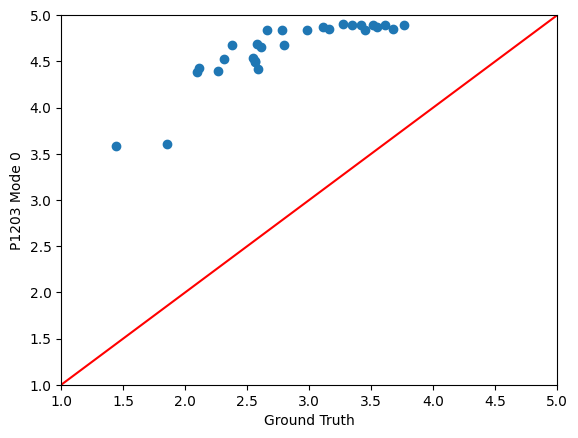

In [17]:
plt.scatter(qoe_ground_truth, p1203_qoe)
plt.plot([1, 5], [1, 5], color = 'red')
plt.axis([1, 5, 1, 5])
plt.xlabel("Ground Truth")
plt.ylabel("P1203 Mode 0")
plt.savefig("./figures/initial_scatter_plot_BOTH.pdf")

Spearmann
              Ground truth    P.1203
Ground truth      1.000000  0.904053
P.1203            0.904053  1.000000


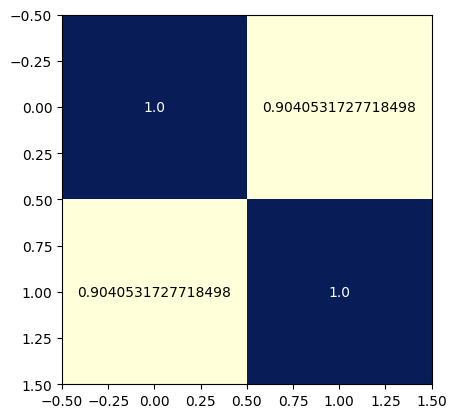

Pearson
              Ground truth    P.1203
Ground truth      1.000000  0.847379
P.1203            0.847379  1.000000


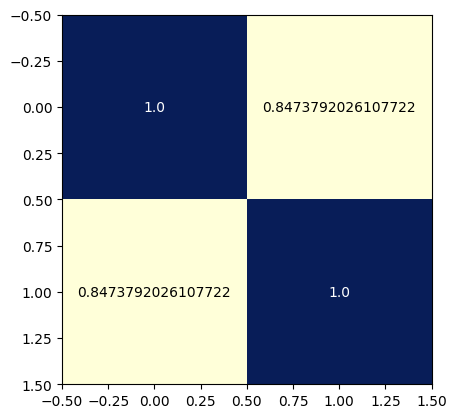

In [18]:
#import seaborn as sns
df_correlation = pd.DataFrame({'Ground truth': qoe_ground_truth,
                              'P.1203': p1203_qoe})

spear_corr = df_correlation.corr(method = 'spearman') #pearson
print("Spearmann")
print(spear_corr)

#sns.heatmap(corr, cmap='YlGnBu', annot = True)
plt.imshow(spear_corr, cmap='YlGnBu')

plt.text(0, 0, spear_corr['Ground truth']['Ground truth'], ha = "center", va = "center", color = "w")
plt.text(1, 0, spear_corr['Ground truth']['P.1203'], ha = "center", va = "center", color = "black")
plt.text(0, 1, spear_corr['P.1203']['Ground truth'], ha = "center", va = "center", color = "black")
plt.text(1, 1, spear_corr['P.1203']['P.1203'], ha = "center", va = "center", color = "w")

plt.savefig("./figures/correlation_spearman_1203_1080p" + "groundtruth" + "_BOTH.pdf")
plt.show()

pearson_corr = df_correlation.corr(method = 'pearson') #spearman
print("Pearson")
print(pearson_corr)

#sns.heatmap(corr, cmap='YlGnBu', annot = True)
plt.imshow(pearson_corr, cmap='YlGnBu')

plt.text(0, 0, pearson_corr['Ground truth']['Ground truth'], ha = "center", va = "center", color = "w")
plt.text(1, 0, pearson_corr['Ground truth']['P.1203'], ha = "center", va = "center", color = "black")
plt.text(0, 1, pearson_corr['P.1203']['Ground truth'], ha = "center", va = "center", color = "black")
plt.text(1, 1, pearson_corr['P.1203']['P.1203'], ha = "center", va = "center", color = "w")

plt.savefig("./figures/correlation_pearson_1203_1080p" + "groundtruth" + "_BOTH.pdf")
plt.show()



# P1203.1 Pv coefficients updates


In [19]:
# Quant(a1, a2, a3, a4) = a1 + a2*ln(a3+ln(bitrate) + ln(br*br/(codRes*fr) + a4))

# MOSq(q1, q2, q3) = q1 + q2*exp(q3*Quant)
# MOSq = max(min(MOSq, 5), 1)

# Dq = max(min(100 - RfromMOS(MOSq), 100), 0)

# MOSfromR:
#     MOS = MOS_min + (MOS_max - MOS_min) * R/100 + R*(R-60)(100-R)*0.000007
#     MOS = min(MOS_max, max(MOS, MOS_min))
#     Calculate MOSfromR, R from 0 -> 100, step 0.25

In [20]:
from functools import lru_cache
from itertools import permutations
import json
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from itu_p1203 import P1203Standalone
from itu_p1203 import P1203Pv


ModuleNotFoundError: No module named 'itu_p1203_new'

In [191]:
f = open("./mode0-bothtests.json")
input_data = json.load(f)
# input_data

In [ ]:
ground_truth_qoe_df = pd.read_csv('./results/test_scores.csv')
#ground_truth_qoe_df[['object', 'encoder', 'qual', 'dist']] = ground_truth_qoe_df.objects.str.split('_', expand=True)
ground_truth_qoe_df[['object', 'start_qual', 'end_qual', 'dist']] = pd.DataFrame(ground_truth_qoe_df['objects'].apply(split_column).to_list(), index=ground_truth_qoe_df.index)
ground_truth_qoe_df
ground_truth_qoe_df['rate_scaled'] = ground_truth_qoe_df['rate']

ground_truth_qoe_df

In [ ]:
ground_truth_qoe_df = ground_truth_qoe_df[['object', 'start_qual', 'end_qual', 'rate_scaled']]
ground_truth_qoe_df

In [194]:
# remove outliers using boxplot method
vpcc_group_columns = ['object', 'start_qual', 'end_qual']
configurations = ground_truth_qoe_df.groupby(vpcc_group_columns,as_index=False)

def boxplot_outlier_filter(frame):
    """
    Outlier filter using interquantile range (filter below Q1 - 1.5 IQR and above Q3 + 1.5 IQR)

    :param frame: data frame
    :return: filtered frame
    """
    q1 = frame.quantile(0.25, numeric_only=True)["rate_scaled"]
    q3 = frame.quantile(0.75, numeric_only=True)["rate_scaled"]
    
    # interquantile range
    iqr = q3 - q1
    fence_low = q1 - (1.5*iqr)
    fence_high = q3 + (1.5*iqr)
    filtered = (frame["rate_scaled"] >= fence_low) & (frame["rate_scaled"] <= fence_high)
    return frame.loc[filtered]

# for each configuration, filter outliers
df_vpcc_filtered = None
for _, frame in configurations:
    #print(boxplot_outlier_filter(frame))
    df_vpcc_filtered = pd.concat([df_vpcc_filtered, boxplot_outlier_filter(frame)], axis=0)

df_vpcc_filtered = df_vpcc_filtered.reset_index(drop=True)
# groups = df_vpcc_filtered.groupby(vpcc_group_columns,as_index=False)


In [ ]:
ground_truth_qoe_df = df_vpcc_filtered.loc[df_vpcc_filtered['object'].isin(['BlueSpin', 'CasualSquat', 'LongDress', 'Loot'])]

# as_index = False to avoid subcolumns
ground_truth_qoe_grouped_df = ground_truth_qoe_df.groupby(['object', 'start_qual', 'end_qual'],as_index=False).aggregate(lambda x: tuple(x))

ground_truth_qoe_grouped_df

In [196]:
# bitratesMbpsNew = {
#     'BlueSpin': {'r01': 1.75, 'r02': 2.29, 'r03': 3.17, 'r04': 7.53, 'r05': 12.62},
#     'CasualSquat':  {'r01': 2.50, 'r02': 3.91, 'r03': 6.66, 'r04': 19.51, 'r05': 31.11},
#     'ReadyForWinter':  {'r01': 1.97, 'r02': 2.58, 'r03': 3.61, 'r04': 9.34, 'r05': 16.59},
#     'FlowerDance':  {'r01': 2.66, 'r02': 4.24, 'r03': 7.12, 'r04': 22.81, 'r05': 39.35},
# }

bitrates_kbps_new = {
    'BlueSpin': {'r01': 14000.33, 'r02': 18358.77, 'r03': 25381.74, 'r04': 60218.56, 'r05': 100957.13},
    'CasualSquat':  {'r01': 20028.41, 'r02': 31350.91, 'r03': 53280.41, 'r04': 156102.30, 'r05': 248934.89},
    'ReadyForWinter': { 'r01': 15823.20, 'r02': 20687.30, 'r03': 28919.76, 'r04': 74742.73, 'r05': 132748.28 },
    'FlowerDance': { 'r01': 21305.45,  'r02': 33934.77,  'r03': 57028.55, 'r04': 182492.95, 'r05': 314833.07}
}

resolution_map_new = {
    'r01': '640x360', # worse than 420p
    'r02': '852x480', # exactly 480p
    'r03': '1192x672', # bit worse than 720p
    'r04': '1533x864', # a bit better than 720p
    'r05': '1920x1080', # exactly 1080p

}

# bitratesMbpsOld = {
#     'LongDress': {'r1': 4.64, 'r3': 14.05, 'r5':46.78},
#     'Loot': {'r1': 2.28, 'r3': 5.63, 'r5': 16.68},
#     'RedAndBlack': {'r1': 3.39, 'r3': 7.55, 'r5': 22.9},
#     'Soldier': {'r1': 4.38, 'r3': 11.58, 'r5': 35.29}
# }

bitrates_kbps_old = {
    'LongDress': { 'r1': 45330.51, 'r3': 137209.71, 'r5': 456825.40 },
    'Loot': { 'r1': 22223.74, 'r3': 54941.94, 'r5': 162842.81 },
    'RedAndBlack': { 'r1': 33068.13, 'r3': 73753.55, 'r5': 223673.06 },
    'Soldier': { 'r1': 42745.16, 'r3': 113102.48, 'r5': 344626.97 }
}

resolution_map_old = {
    'r1': '854x480', # old dataset 480p
    'r3': '1280x720', # old dataset 720p
    'r5': '1920x1080' # old dataset 1080p
}

In [197]:
def calculate_p1203(current_coeffs):
    p1203_results = {
        'object': [],
        'start_qual' : [],
        'end_qual' : [],
        'start_bitrate': [],
        'end_bitrate': [],
        'p1203_qoe': []
    }

    for video in list(bitrates_kbps_old.keys()):
        bitrate_permutations = permutations(list(bitrates_kbps_old[video].values()), 2)
        quality_permutations = permutations(list(bitrates_kbps_old[video].keys()),2)

        bitrates=list(bitrate_permutations)
        qualities = list(quality_permutations)

        for bitrate in list(bitrates_kbps_old[video].values()):
            bitrates.append((bitrate, bitrate))

        for quality in list(bitrates_kbps_old[video].keys()):
            qualities.append((quality, quality))

        for bitrate, quality in zip(bitrates, qualities):
            p1203_results['object'].append(video)
            p1203_results['start_qual'].append(quality[0])
            p1203_results['end_qual'].append(quality[1])
            p1203_results['start_bitrate'].append(bitrate[0])
            p1203_results['end_bitrate'].append(bitrate[1])

            input_data['I13']['segments'][0]['bitrate'] = bitrate[0]
            input_data['I13']['segments'][0]['resolution'] = resolution_map_old[quality[0]]
            input_data['I13']['segments'][1]['bitrate'] = bitrate[1]
            input_data['I13']['segments'][1]['resolution'] = resolution_map_old[quality[1]]

            # the old dataset videos are 30 fps and 10 seconds in sequence length
            input_data['I13']['segments'][0]['fps'] = 30
            input_data['I13']['segments'][1]['fps'] = 30
            input_data['I13']['segments'][0]['duration'] = 5
            input_data['I13']['segments'][1]['duration'] = 5
            input_data['I13']['segments'][1]['start'] = 5

            p1203_results['p1203_qoe'].append(P1203Standalone(input_data, coeffs=current_coeffs).calculate_complete()['O46'])

            #print(video)
            print("input_data")
            print(input_data)
            print(P1203Standalone(input_data, coeffs = current_coeffs).calculate_complete()['O46'])

    for video in list(bitrates_kbps_new.keys()):   
        bitrates = list(bitrates_kbps_new[video].values())
        qualities = list(bitrates_kbps_new[video].keys())

        for bitrate, quality in zip(bitrates, qualities):
            p1203_results['object'].append(video)
            p1203_results['start_qual'].append(quality)
            p1203_results['end_qual'].append(quality)
            p1203_results['start_bitrate'].append(bitrate)
            p1203_results['end_bitrate'].append(bitrate)

            input_data['I13']['segments'][0]['bitrate'] = bitrate
            input_data['I13']['segments'][0]['resolution'] = resolution_map_new[quality]
            input_data['I13']['segments'][1]['bitrate'] = bitrate
            input_data['I13']['segments'][1]['resolution'] = resolution_map_new[quality]

            # the ComPEQ-MR videos are 25 fps and 20 seconds in sequence length
            input_data['I13']['segments'][0]['fps'] = 25
            input_data['I13']['segments'][1]['fps'] = 25
            input_data['I13']['segments'][0]['duration'] = 10
            input_data['I13']['segments'][1]['duration'] = 10
            input_data['I13']['segments'][1]['start'] = 10 # make sure to mark the start of the second segment at 10 seconds for new videos

            p1203_results['p1203_qoe'].append(P1203Standalone(input_data, coeffs = current_coeffs).calculate_complete()['O46'])

            #print(video)
            print("input_data")
            print(input_data)
            print(P1203Standalone(input_data, coeffs = current_coeffs).calculate_complete()['O46'])
    print(p1203_results)
    return p1203_results
    




In [198]:
def calculate_rmse(p1203_results, mos):
    print("p1203_results")
    print(p1203_results)
    print("mos")
    print(mos)
    joined_qoe = p1203_results.merge(mos)
    rmse_arr = []
    print("joined_qoe")
    print(joined_qoe)

    for idx in np.arange(joined_qoe.shape[0]):
        
        print("joined_qoe.shape[0]")
        print(joined_qoe.shape[0])
        targets = joined_qoe.iloc[idx,:]['rate_scaled']
        print("targets")
        print(targets)
        print(len(targets))
        predictions = np.full(len(targets), joined_qoe.loc[joined_qoe.index[idx], 'p1203_qoe'])
        print("predictions")
        print(predictions)
        print(len(predictions))
        rmse_arr.append(np.sqrt(np.mean((predictions-targets)**2)))
        print("rmse_arr")
        print(rmse_arr)
    
    return np.average(rmse_arr)


In [199]:
from datetime import datetime

_COEFFS = {
        "u1": 72.61,
        "u2": 0.32,
        "t1": 30.98,
        "t2": 1.29,
        "t3": 64.65,
        "q1": 4.66,
        "q2": -0.07,
        "q3": 4.06,
        "mode0": {
            "a1": 11.9983519,
            "a2": -2.99991847,
            "a3": 41.2475074001,
            "a4": 0.13183165961,
        },
        "mode1": {
            "a1": 5.00011566,
            "a2": -1.19630824,
            "a3": 41.3585049,
            "a4": 0,
            "c0": -0.91562479,
            "c1": 0,
            "c2": -3.28579526,
            "c3": 20.4098663,
        },
        "htv_1": -0.60293,
        "htv_2": 2.12382,
        "htv_3": -0.36936,
        "htv_4": 0.03409,
    }

# this function isnt being called normally anywhere
def finetune_coeffs():
    min_rmse = sys.float_info.max
    optimized_coeffs = _COEFFS
    optimized_p1203_qoe  =[]

    # for _COEFFS['u1'] in np.arange(50,100):
    #     for _COEFFS['u2'] in np.arange(1):
            # for _COEFFS['t1'] in np.arange(1):
            #     for _COEFFS['t2'] in np.arange(1):
            #         for _COEFFS['t3'] in np.arange(1):
                        # for _COEFFS['q1'] in np.arange(1):
                        #     for _COEFFS['q2'] in np.arange(1):
                        #         for _COEFFS['q3'] in np.arange(1):
    for _COEFFS['mode0']['a1'] in np.arange(1, 15, 0.5): # 0.5 range originally
        for _COEFFS['mode0']['a2'] in np.arange(-5, 0, 0.5): # 0.5 range originally
            for _COEFFS['mode0']['a3'] in np.arange(0, 80, 1): # 1 range originally
                for _COEFFS['mode0']['a4'] in np.arange(0, 5, 0.5): # 0.5 range originally
                    # print(_COEFFS)

                    qoe_p1203_dict = calculate_p1203(_COEFFS)
                    p1203_df = pd.DataFrame.from_dict(qoe_p1203_dict)

                    # Fine tune aka train with BlueSpin and CasualSquat
                    p1203_df = p1203_df.loc[p1203_df['object'].isin(['BlueSpin', 'CasualSquat', 'LongDress', 'Loot'])]
                    grouped_p1203_qoe = p1203_df.groupby(['object', 'start_qual', 'end_qual'],as_index=False).mean()
                    #print("grouped_p1203_qoe")
                    #print(grouped_p1203_qoe)

                    print("timestamp")
                    print(datetime.now())
                    print("COEFFS: " + str(_COEFFS['mode0']['a1']) + " " + str(_COEFFS['mode0']['a2']) + " " + str(_COEFFS['mode0']['a3']) + " " + str(_COEFFS['mode0']['a4']))

                    rmse = calculate_rmse(grouped_p1203_qoe, ground_truth_qoe_grouped_df)
                    print("Calcd RMSE: " + str(rmse))
                    print("Current min RMSE: " + str(min_rmse))
                    if rmse < min_rmse:   
                        print("==> NEW MIN RMSE: " + str(rmse))
                        print("==> MIN RMSE _COEFFS: " + str(_COEFFS))
                        
                        optimized_coeffs = _COEFFS
                        min_rmse = rmse
                        optimized_p1203_qoe = list(grouped_p1203_qoe['p1203_qoe'])

    return optimized_coeffs, optimized_p1203_qoe, min_rmse

In [ ]:
from scipy.optimize import minimize, Bounds, differential_evolution, basinhopping

# objective function to minimise
def objective_function(trial_coeffs, multiplier=1):
    current_coeffs = _COEFFS
    current_coeffs['mode0']['a1'] = trial_coeffs[0]
    current_coeffs['mode0']['a2'] = trial_coeffs[1]
    current_coeffs['mode0']['a3'] = trial_coeffs[2]
    current_coeffs['mode0']['a4'] = trial_coeffs[3]

    qoe_p1203_dict = calculate_p1203(current_coeffs)
    p1203_df = pd.DataFrame.from_dict(qoe_p1203_dict)
    p1203_df = p1203_df.loc[p1203_df['object'].isin(['BlueSpin', 'CasualSquat', 'LongDress', 'Loot'])]
    grouped_p1203_qoe = p1203_df.groupby(['object', 'start_qual', 'end_qual'],as_index=False).mean()
    print("COEFFS: " + str(current_coeffs['mode0']['a1']) + " " + str(current_coeffs['mode0']['a2']) + " " + str(current_coeffs['mode0']['a3']) + " " + str(current_coeffs['mode0']['a4']))

    rmse = calculate_rmse(grouped_p1203_qoe, ground_truth_qoe_grouped_df)
    print("Calcd RMSE: " + str(rmse))
    #print("Current min RMSE: " + str(min_rmse))
    return rmse

initial_coeffs = [12,-3,41,0]

optimization_method = "basinhopping"
#optimization_method = "differential_evolution"

bounds = [(1,15), (-5, 5), (0, 80), (0, 5)]
#bounds = [(0,100), (0,100), (0,100), (0,100)]
#bounds = [(-100,100), (-100,100), (-100,100), (-100,100)]
#bounds = Bounds(-100,100)

#result = minimize(objective_function, initial_coeffs, method='L-BFGS-B', bounds=bounds)

if(optimization_method == "basinhopping"):
    result2 = basinhopping(objective_function, initial_coeffs, minimizer_kwargs={'bounds':bounds, 'method':'L-BFGS-B'})
    print("optimised coeffs basinhopping:" + str(result2.x))
    print("objective funciton value:" + str(result2.fun))
else:
    result = differential_evolution(objective_function, bounds, strategy='rand2bin', disp=True, workers=-1)
    print("Optimized coefficients:", str(result.x))
    print("Objective function value:", str(result.fun))


In [ ]:
if(optimization_method == "basinhopping"):
    print("optimised coeffs basinhopping:", str(result2.x))
    print("objective funciton value basinhopping:", str(result2.fun))
else: 
    print("Optimized coefficients differential evolution:", result.x)
    print("Objective function value differential evolution:", result.fun)
    print("Optimization message differential evolution:", result.message)

In [158]:
#optimized_coeffs, p1203_qoe_list, min_rmse =  finetune_coeffs()
#print("timestamp")
#print(datetime.now())
#print("FINAL RESULT")
#print(optimized_coeffs, p1203_qoe_list, min_rmse)

In [159]:
#print(min_rmse)
#print(optimized_coeffs)
#print(ground_truth_qoe_df.groupby(['object', 'qual'],as_index=False).mean()['rate_scaled'])


In [160]:
#==============================================================================================================================
#FOUND THE BEST

In [161]:
ground_truth_qoe_list = list(ground_truth_qoe_df.groupby(['object', 'start_qual', 'end_qual'],as_index=False).mean()['rate_scaled'])
ground_truth_qoe_list = ground_truth_qoe_list

In [ ]:
#coeffs = {'u1': 72.61, 'u2': 0.32, 't1': 30.98, 't2': 1.29, 't3': 64.65, 'q1': 4.4, 'q2': -1.5, 'q3': 1.5, 'mode0': {'a1': 5, 'a2': -1.0, 'a3': 130, 'a4': 4.0}, 'mode1': {'a1': 5.00011566, 'a2': -1.19630824, 'a3': 41.3585049, 'a4': 0, 'c0': -0.91562479, 'c1': 0, 'c2': -3.28579526, 'c3': 20.4098663}, 'htv_1': -0.60293, 'htv_2': 2.12382, 'htv_3': -0.36936, 'htv_4': 0.03409}
coeffs = _COEFFS

if(optimization_method == "basinhopping"):
    print("basinhopping results")
    print(result2.x[0])
    print(result2.x[1])
    print(result2.x[2])
    print(result2.x[3])

    coeffs['mode0']['a1'] = result2.x[0]
    coeffs['mode0']['a2'] = result2.x[1]
    coeffs['mode0']['a3'] = result2.x[2]
    coeffs['mode0']['a4'] = result2.x[3]
else: 
    print("differential evolution results")
    print(result.x[0])
    print(result.x[1])
    print(result.x[2])
    print(result.x[3])

    coeffs['mode0']['a1'] = result.x[0]
    coeffs['mode0']['a2'] = result.x[1]
    coeffs['mode0']['a3'] = result.x[2]
    coeffs['mode0']['a4'] = result.x[3]
   

#coeffs = optimized_coeffs
print(coeffs)

qoe_p1203_dict = calculate_p1203(coeffs)
p1203_df = pd.DataFrame.from_dict(qoe_p1203_dict)

p1203_df = p1203_df.loc[p1203_df['object'].isin(['BlueSpin', 'CasualSquat', 'LongDress', 'Loot'])]
grouped_p1203_qoe = p1203_df.groupby(['object', 'start_qual', 'end_qual'],as_index=False).mean()
grouped_p1203_qoe

In [ ]:
p1203_qoe_list = list(grouped_p1203_qoe['p1203_qoe'])
plt.scatter(ground_truth_qoe_list, p1203_qoe_list)
plt.plot([1, 5], [1, 5], color = 'red')
plt.axis([1, 5, 1, 5])
plt.xlabel("Ground Truth")
plt.ylabel("Fine-tuned P1203 Mode 0")

In [ ]:
#import seaborn as sns

df_correlation = pd.DataFrame({
    "Ground truth": ground_truth_qoe_list,
    "P.1203": p1203_qoe_list
})

#corr_method = 'spearman'
#corr = df_correlation.corr(method=corr_method)
#sns.heatmap(corr, cmap='YlGnBu', annot = True)
#plt.savefig('./figures/correlation_heatmap_' + corr_method + '_optimized_BOTH.pdf')
#plt.show()

spear_corr = df_correlation.corr(method = 'spearman') #pearson
print("Spearmann")
print(spear_corr)
print(spear_corr.shape)
print(spear_corr["Ground truth"]["P.1203"])

#sns.heatmap(corr, cmap='YlGnBu', annot = True)
plt.imshow(spear_corr, cmap='YlGnBu')

plt.text(0, 0, spear_corr['Ground truth']['Ground truth'], ha = "center", va = "center", color = "w")
plt.text(1, 0, spear_corr['Ground truth']['P.1203'], ha = "center", va = "center", color = "black")
plt.text(0, 1, spear_corr['P.1203']['Ground truth'], ha = "center", va = "center", color = "black")
plt.text(1, 1, spear_corr['P.1203']['P.1203'], ha = "center", va = "center", color = "w")


plt.savefig("./figures/correlation_spearman_optimized" + optimization_method + "_BOTH.pdf")
plt.show()

pearson_corr = df_correlation.corr(method = 'pearson') #spearman
print("Pearson")
print(pearson_corr)

#sns.heatmap(corr, cmap='YlGnBu', annot = True)
plt.imshow(pearson_corr, cmap='YlGnBu')

plt.text(0, 0, pearson_corr['Ground truth']['Ground truth'], ha = "center", va = "center", color = "w")
plt.text(1, 0, pearson_corr['Ground truth']['P.1203'], ha = "center", va = "center", color = "black")
plt.text(0, 1, pearson_corr['P.1203']['Ground truth'], ha = "center", va = "center", color = "black")
plt.text(1, 1, pearson_corr['P.1203']['P.1203'], ha = "center", va = "center", color = "w")


plt.savefig("./figures/correlation_pearson_optimized" + optimization_method + "_BOTH.pdf")
plt.show()


In [165]:
# corr_method = 'pearson'
# corr = df_correlation.corr(method=corr_method)
# sns.heatmap(corr, cmap='YlGnBu', annot = True)
# plt.savefig('./figures/correlation_heatmap_' + corr_method + '_optimized_BOTH.pdf')
# plt.show()

In [166]:
#==============================================================================================================================
#VALIDATING with ReadyForWinter and FlowerDance

In [ ]:
coeffs = {'u1': 72.61, 'u2': 0.32, 't1': 30.98, 't2': 1.29, 't3': 64.65, 'q1': 4.4, 'q2': -1.5, 'q3': 1.5, 'mode0': {'a1': 5, 'a2': -1.0, 'a3': 130, 'a4': 4.0}, 'mode1': {'a1': 5.00011566, 'a2': -1.19630824, 'a3': 41.3585049, 'a4': 0, 'c0': -0.91562479, 'c1': 0, 'c2': -3.28579526, 'c3': 20.4098663}, 'htv_1': -0.60293, 'htv_2': 2.12382, 'htv_3': -0.36936, 'htv_4': 0.03409}

qoe_p1203_dict = calculate_p1203(coeffs)
qoe_p1203_df = pd.DataFrame(qoe_p1203_dict)
qoe_p1203_df = qoe_p1203_df.loc[qoe_p1203_df['object'].isin(['ReadyForWinter', 'FlowerDance', 'RedAndBlack', 'Soldier'])]
                                # & ((qoe_p1203_df['qual'].isin(['r01']) & qoe_p1203_df['end_quality'].isin(['r1'])) |
                                #  (qoe_p1203_df['start_quality'].isin(['r3']) & qoe_p1203_df['end_quality'].isin(['r3'])) |
                                #  (qoe_p1203_df['start_quality'].isin(['r5']) & qoe_p1203_df['end_quality'].isin(['r5']))) ]
qoe_validation = qoe_p1203_df.groupby(['object', 'start_qual', 'end_qual'],as_index=False).mean()
qoe_validation

In [ ]:
# Get ground truth qoe for these sequences
ground_truth_qoe_df = df_vpcc_filtered.loc[df_vpcc_filtered['object'].isin(['ReadyForWinter', 'FlowerDance', 'RedAndBlack', 'Soldier'])]
ground_truth_qoe_grouped_df = ground_truth_qoe_df.groupby(['object', 'start_qual', 'end_qual'],as_index=False).aggregate(lambda x: tuple(x))
ground_truth_qoe_grouped_df

In [ ]:
calculate_rmse(qoe_validation, ground_truth_qoe_grouped_df)

In [ ]:
ground_truth_list = list(ground_truth_qoe_df.groupby(['object', 'start_qual', 'end_qual'],as_index=False).mean()['rate_scaled'])
qoe_validation_list = list(qoe_validation['p1203_qoe'])
ground_truth_list

In [ ]:
plt.scatter(ground_truth_list, qoe_validation_list)
plt.plot([1, 5], [1, 5], color='red')
plt.axis([1, 5, 1, 5])
plt.xlabel('Ground Truth')
plt.ylabel('Fine-tuned P1203 Mode 0 - Validation')
plt.show()

In [ ]:
corr_method = 'spearman'
corr_df = pd.DataFrame({
    'Fine-tuned P1203': qoe_validation_list,
    'Ground truth': ground_truth_list
})

corr_methods = ['spearman', 'pearson']

for corr_method in corr_methods:
    corr = corr_df.corr(method=corr_method)
    #sns.heatmap(corr, cmap='YlGnBu', annot = True)
    plt.imshow(corr, cmap='YlGnBu')

    plt.text(0, 0, corr['Ground truth']['Ground truth'], ha = "center", va = "center", color = "w")
    plt.text(1, 0, corr['Ground truth']['Fine-tuned P1203'], ha = "center", va = "center", color = "black")
    plt.text(0, 1, corr['Fine-tuned P1203']['Ground truth'], ha = "center", va = "center", color = "black")
    plt.text(1, 1, corr['Fine-tuned P1203']['Fine-tuned P1203'], ha = "center", va = "center", color = "w")

    plt.savefig('./figures/correlation_heatmap_' + corr_method + optimization_method + '_validation_BOTH.pdf')
    plt.title(corr_method)
    plt.show()

In [ ]:
# original P1203
_COEFFS = {
        "u1": 72.61,
        "u2": 0.32,
        "t1": 30.98,
        "t2": 1.29,
        "t3": 64.65,
        "q1": 4.66,
        "q2": -0.07,
        "q3": 4.06,
        "mode0": {
            "a1": 11.9983519,
            "a2": -2.99991847,
            "a3": 41.2475074001,
            "a4": 0.13183165961,
        },
        "mode1": {
            "a1": 5.00011566,
            "a2": -1.19630824,
            "a3": 41.3585049,
            "a4": 0,
            "c0": -0.91562479,
            "c1": 0,
            "c2": -3.28579526,
            "c3": 20.4098663,
        },
        "htv_1": -0.60293,
        "htv_2": 2.12382,
        "htv_3": -0.36936,
        "htv_4": 0.03409,
    }

qoe_p1203_dict = calculate_p1203(_COEFFS)
qoe_p1203_df = pd.DataFrame(qoe_p1203_dict)
qoe_p1203_df = qoe_p1203_df.loc[qoe_p1203_df['object'].isin(['ReadyForWinter', 'FlowerDance', 'RedAndBlack', 'Soldier'])]
                                #  & 
                                # ((qoe_p1203_df['start_quality'].isin(['r1']) & qoe_p1203_df['end_quality'].isin(['r1'])) |
                                #  (qoe_p1203_df['start_quality'].isin(['r3']) & qoe_p1203_df['end_quality'].isin(['r3'])) |
                                #  (qoe_p1203_df['start_quality'].isin(['r5']) & qoe_p1203_df['end_quality'].isin(['r5']))) ]
qoe_original_p1203 = qoe_p1203_df.groupby(['object', 'start_qual', 'end_qual'],as_index=False).mean()
qoe_original_p1203

In [ ]:
print(calculate_rmse(qoe_original_p1203, ground_truth_qoe_grouped_df))
qoe_original_p1203_list = list(qoe_original_p1203['p1203_qoe'])

In [ ]:
plt.scatter(ground_truth_list, qoe_original_p1203_list)
plt.plot([1, 5], [1, 5], color='red')
plt.axis([1, 5, 1, 5])
plt.xlabel('Ground Truth')
plt.ylabel('Original P1203 Mode 0')
plt.show()

In [ ]:
corr_all_df = pd.DataFrame({
    "Ground truth": ground_truth_list,
    # "Fine-tuned P1203": qoe_validation_list,
    "Original P1203": qoe_original_p1203_list
})

corr_methods = ['spearman', 'pearson']
for corr_method in corr_methods:
    corr = corr_all_df.corr(method=corr_method)
    #sns.heatmap(corr, cmap='YlGnBu', annot=True)
    plt.imshow(corr, cmap='YlGnBu')

    plt.text(0, 0, corr['Ground truth']['Ground truth'], ha = "center", va = "center", color = "w")
    plt.text(1, 0, corr['Ground truth']['Original P1203'], ha = "center", va = "center", color = "black")
    plt.text(0, 1, corr['Original P1203']['Ground truth'], ha = "center", va = "center", color = "black")
    plt.text(1, 1, corr['Original P1203']['Original P1203'], ha = "center", va = "center", color = "w")
    
    plt.title(corr_method)
    plt.show()